# KNIT7
# Precision Timestamp for Packets and Events 

## Timestamp Service Overview(You can pull/run the containers on any node in your slice)

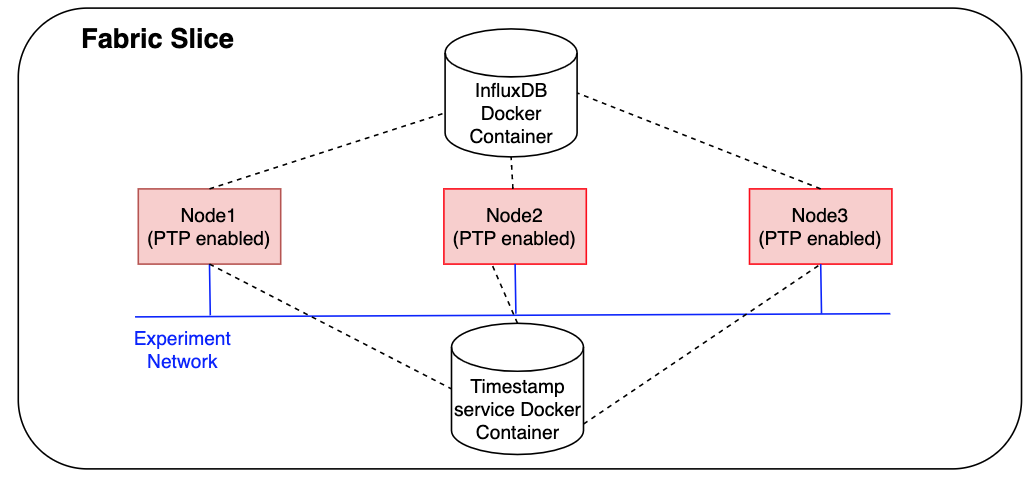

## Prerequisites

##### The node to run the timestamp service must have **docker**, **linuxptp** installed and configured.
##### Make sure there is no docker containers named timestamp or influxdb running on the nodes 

## Imports

In [ ]:
import json
import os
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
from mflib.mf_timestamp import mf_timestamp 
try:
    fablib = fablib_manager()    
    fablib.show_config()
except Exception as e:
    print(f"Exception: {e}")

## Slice info

In [ ]:
# Change your slice name and node name(This is an example of a 4 node topology)
slice_name="Slice for KNIT7 Precision Timing Tutorial"
container_name="timestamp"
node1_name = 'node1'
node2_name = 'node2'
node3_name = 'node3'
node4_name = 'node4'

## Find all Experiment Nodes

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")

print (slice)    

try:
    node1 = slice.get_node(name=node1_name)
    node2 = slice.get_node(name=node2_name)
    node3 = slice.get_node(name=node3_name)
    node4 = slice.get_node(name=node4_name)
    node_list=[node1,node2,node3,node4]
    
except Exception as e:
    print(f"Fail: {e}")

## Ensure PTP is running

In [ ]:
for node in node_list:
    print (f"{node.get_name()} on {node.get_site()}:")
    node.execute("ps -ef | grep phc2sys")

## Setup timestamp service on nodes

### Pull and run the timestamp docker image as a container on node1

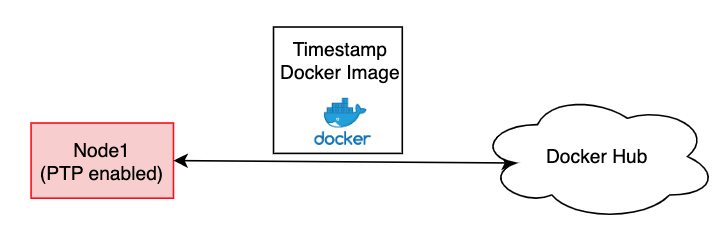

In [ ]:
# Specify the bind mount volume
timestamp_bind_mount_volume = "/home/ubuntu/timestamp/"
cmd = f'''
      sudo docker run -dit \
      -v {timestamp_bind_mount_volume}:/root/services/timestamp/output_files/ \
      --pid=host --network=host --privileged \
      --name timestamp fabrictestbed/timestamp:0.1.2
      '''
node1.execute(cmd)

### Check on Node1 if timestamp docker container is running

In [ ]:
command = f"sudo docker ps"
stdout, stderr= node1.execute(command)

## Create the object

In [ ]:
ts = mf_timestamp(slice_name=slice_name, container_name=container_name)

## Specify the name of the timestamp experiment

In [ ]:
packet_test_name="packet-test"
event_test_name="event-test"

<font color=blue size="6">*Timestamping Packets*</font>
### This method will first trigger tcpdump to record packets and then process the results

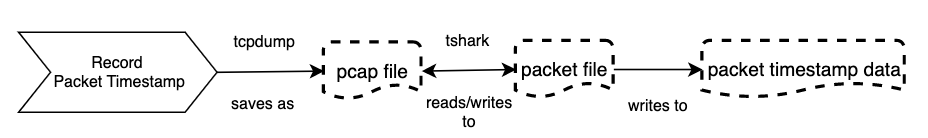

In [ ]:
# To see which interface to use
slice.list_interfaces()

### Prepare to run iperf tests

#### Run iperf3 test

In [ ]:
# find the ip address of an interface
# Specify the name of the experiment network you set up on node1
node1_network_name="net1"
for iface in node1.get_interfaces():
    if (node1_network_name in iface.get_network().get_name()):
        node1_experiment_net_IP = iface.get_ip_addr()
        node1_physical_interface= iface.get_physical_os_interface_name()
print (f"The interface name on Node1 is: {node1_physical_interface} (to be used in the cell below)")
print ("Starting Iperf3 test between node1 and node2")
iperf_server_cmd="sudo timeout 2m iperf3 -s"
iperf_client_cmd=f"sudo timeout 2m iperf3 -c {node1_experiment_net_IP} -t 10 -b 100M"
node1.execute_thread(iperf_server_cmd)
node2.execute_thread(iperf_client_cmd)

In [ ]:
# Start tcpdump to capture packets
ts.record_packet_timestamp(node=node1_name,name=packet_test_name, interface=node1_physical_interface, ipversion="4",
                           protocol="tcp", duration="10", verbose=True)

### Get the recorded packet timestamp from local file

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
packet_records= ts.get_packet_timestamp(node=node1_name, name=packet_test_name)

### Download the packet timestamp data file from Node1

In [ ]:
file_download_path = "/home/fabric/work/packet_timestamp.json" 
ts.download_timestamp_file(node=node1_name, data_type="packet_timestamp",
                           local_file=file_download_path,
                           bind_mount_volume=timestamp_bind_mount_volume)

### Inspect the data format from the downloaded file

In [ ]:
# A list of json objects
with open(file_download_path, 'r') as f:
    result = json.load(f)
print (result[0])

### Local Data Visualization using matplotlib 

In [ ]:
ts.plot_packet_timestamp(json_obj=result)

<font color=blue size="6">*Timestamping Events*</font>

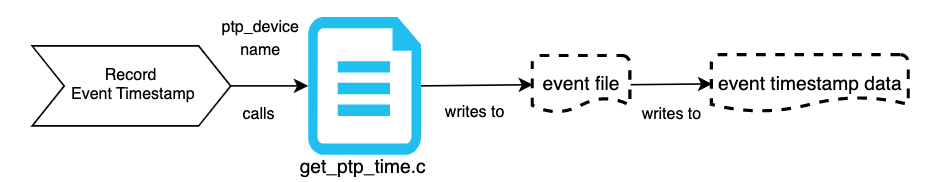

In [ ]:
ts.record_event_timestamp(node=node1_name,name=event_test_name,event="'ram usage above 80 percent'", verbose=True)

### Get the recorded event timestamp

In [ ]:
event_records=ts.get_event_timestamp(node=node1_name,name=event_test_name)